## CH 04-1 로지스틱 회귀

In [2]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [3]:
print(pd.unique(fish['Species']))  # 고유한 값 추출

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


데이터프레임에서 Species 열을 타깃으로 만들고 나머지 열은 입력 데이터로 사용

In [ ]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']]

In [5]:
fish_input.head()

,Weight,Length,Diagonal,Height,Width
0,242.0,25.4,30.0,11.5200,4.0200
1,290.0,26.3,31.2,12.4800,4.3056
2,340.0,26.5,31.1,12.3778,4.6961
3,363.0,29.0,33.5,12.7300,4.4555
4,430.0,29.0,34.0,12.4440,5.1340


In [7]:
# 타깃 데이터 만들기
fish_target = fish['Species']

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

In [8]:
# 표준화 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### k-최근접 이웃 분류기의 확률 예측

In [9]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)  # 최근접 이웃 개수를 3으로 지정
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


* 다중 분류 : 타깃 데이터에 2개 이상의 클래스가 포함된 문제

In [ ]:
print(kn.classes_)  # 알파벳 순으로 정렬되어 있음

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [ ]:
# 테스트 세트에 있는 처음 5개 샘플의 타깃값 예측
print(kn.predict(test_scaled[:5]))  

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [ ]:
import numpy as np
proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))  # 소수점 4번째 자리까지 표기(반올림)

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


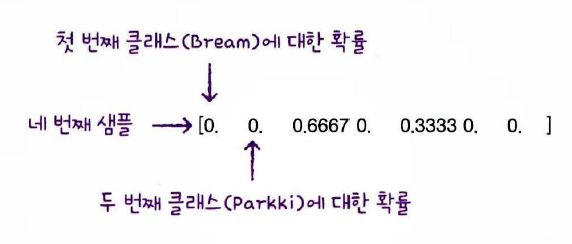
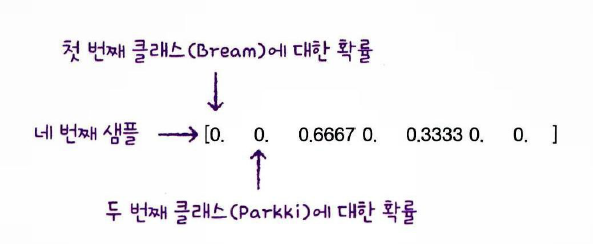

In [13]:
distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target.iloc[indexes[0]])

52     Roach
106    Perch
103    Perch
Name: Species, dtype: object


### 로지스틱 회귀 (분류 모델)

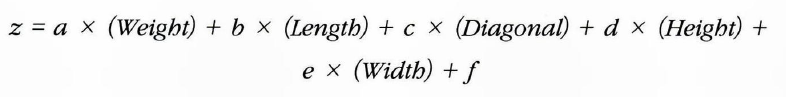

: a,b,c,d,e 는 가중치 혹은 계수 의미

* 시그모이드 함수 : 입력값을 확률로 바꿔주는 함수

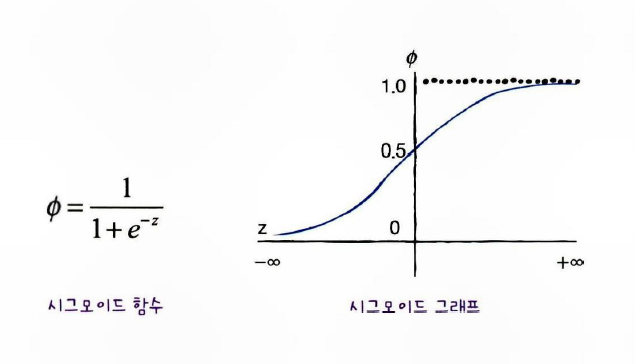

로지스틱 회귀로 이진 분류 수행하기

* 불리언 인덱싱 : 넘파이 배열은 True, False 값을 전달하여 행 선택 가능

In [14]:
char_arr = np.array(['A', "B", "C", "D", "E"])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


In [16]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

데이터로 로지스틱 회귀 모델 훈련하기

In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [20]:
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [21]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99760007 0.00239993]
 [0.02737325 0.97262675]
 [0.99486386 0.00513614]
 [0.98585047 0.01414953]
 [0.99767419 0.00232581]]


In [22]:
print(lr.classes_)

['Bream' 'Smelt']


In [ ]:
print(lr.coef_, lr.intercept_)  # 로지스틱 회귀가 학습한 계수 확인 (가중치, 바이어스)

[[-0.40451732 -0.57582787 -0.66248158 -1.01329614 -0.73123131]] [-2.16172774]


In [24]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02991358  3.57043428 -5.26630496 -4.24382314 -6.06135688]


In [ ]:
from scipy.special import expit  # 시그모이드 함수
print(expit(decisions))

[0.00239993 0.97262675 0.00513614 0.01414953 0.00232581]


로지스틱 회귀로 다중 분류 수행하기

In [ ]:
lr = LogisticRegression(C=20, max_iter=1000)  # C는 규제 강도 조절 값
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [27]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [28]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [29]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [30]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


* 소프트맥스 함수 : 여러 개의 선형 방적식의 출력값을 0~1 사이의 확률로 압축하고 전체 합이 1이 되도록 만듦

(  = 정규화된 지수 함수  )

In [31]:
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.51   1.04   5.17  -2.76   3.34   0.35  -0.63]
 [-10.88   1.94   4.78  -2.42   2.99   7.84  -4.25]
 [ -4.34  -6.24   3.17   6.48   2.36   2.43  -3.87]
 [ -0.69   0.45   2.64  -1.21   3.26  -5.7    1.26]
 [ -6.4   -1.99   5.82  -0.13   3.5   -0.09  -0.7 ]]


In [32]:
from scipy.special import softmax
proba = softmax(decision, axis=1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


## Ch 04-2 확률적 경사 하강법

* 확률적 경사 하강법 : 훈련 세트에서 랜덤하게 하나의 샘플을 고르는 것
* 에포크 : 훈련 세트를 한 번 모두 사용하는 과정
* 미니배치 경사 하강법 : 여러 개의 샘플을 사용해 경사 하강법 수행하는 방식
* 배치 경사 하강법 : 한 번 경사로를 따라 이동하기 위해 전체 샘플 사용

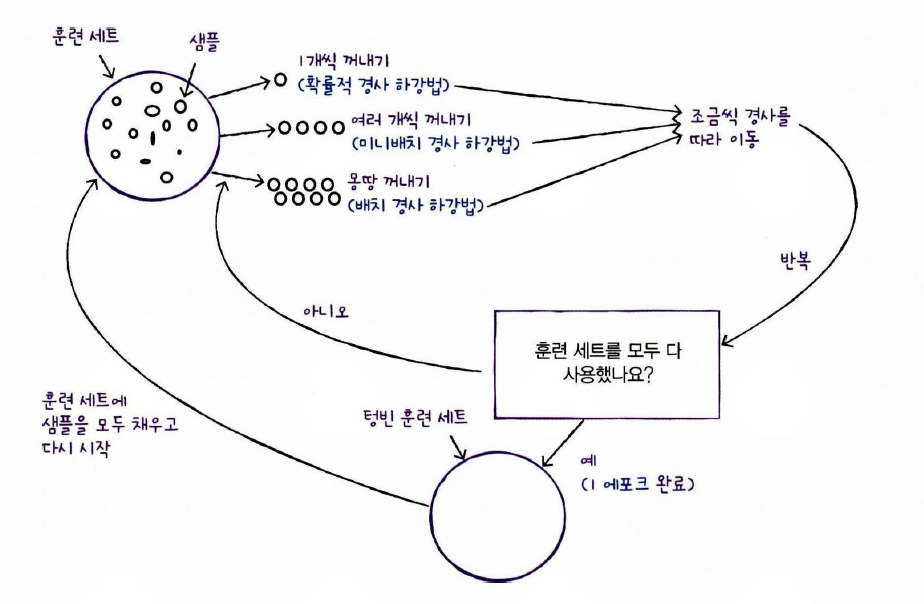

* 손실 함수(비용 함수) : 샘플 하나에 대한 손실

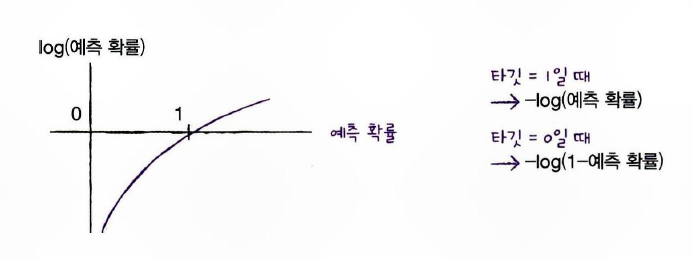

-> 로지스틱 손실 함수, 이진크로스엔트로피 손실 함수

* 크로스 엔트로피 손실 함수 : 다중 분류에서 사용하는 손실 함수

### SDGClassifier

In [1]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv_data')

In [2]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']]
fish_target = fish['Species']

In [4]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [6]:
from sklearn.linear_model import SGDClassifier

In [7]:
sc = SGDClassifier(loss='log_loss', max_iter=10, random_state=42)  
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


/home/user/miniconda3/envs/ai-study/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


loss='log_loss'로 지정하여 로지스틱 손실 함수 지정(클래스마다 이진 분류 모델 만듦)

max_iter은 수행할 에포크 횟수 지정

In [ ]:
sc.partial_fit(train_scaled, train_target)  # 모델을 이어서 훈련
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.7983193277310925
0.775


### 에포크와 과대/과소적합

에포크 횟수가 적으면 모델이 훈련 세트를 덜 학습 -> 과소 적합

에포그 횟수가 많으면 모델이 훈련 세트에 너무 잘 맞음 -> 과대 적합

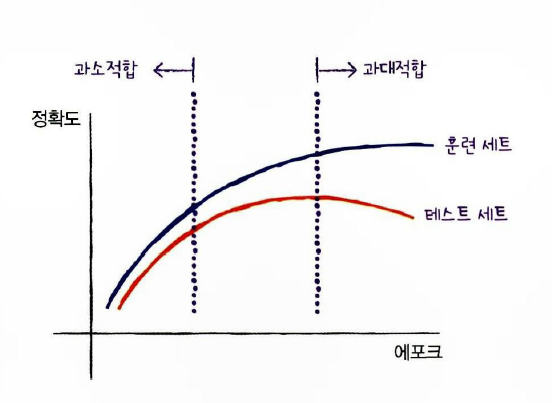

In [9]:
import numpy as np
sc = SGDClassifier(loss='log_loss', random_state=42)
train_score = []
test_score = []
classes = np.unique(train_target)

In [ ]:
for _ in range(0, 300):  # 300번의 에포크 동안 훈련 반복하여 진행
    sc.partial_fit(train_scaled, train_target, classes=classes)
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

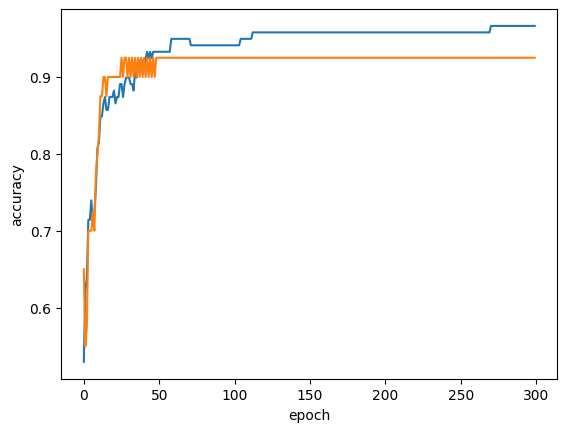

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
# 반복 횟수를 100에 맞추고 다시 훈련해보기
sc = SGDClassifier(loss='log_loss', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925


* 힌지 손실 : 서포트 벡터 머신이라 불리는 머신러닝 알고리즘을 위한 손실 함수

In [13]:
# 힌지 손실을 사용해 같은 반복 횟수 동안 모델 훈련해보기
sc = SGDClassifier(loss='hinge', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.9495798319327731
0.925
